In [ ]:
# --- CELL 1: INSTALL & SETUP ---
print("📦 Installing dependencies for State-of-the-Art Audio Analysis...")
!pip install -q librosa soundfile transformers audiomentations torch torchaudio scikit-learn matplotlib seaborn pandas

import os
import time
import shutil
import random
import numpy as np
import pandas as pd
import torch
import torchaudio
import librosa
import soundfile as sf
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Gain

# 1. Set Seeds for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ System Ready. Using Device: {device}")

# 2. Mount Drive & Extract
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

ZIP_PATH = "/content/drive/MyDrive/FakeVoicey_Ready_Data.zip"
DATA_ROOT = "/content/final_dataset"

if not os.path.exists(DATA_ROOT):
    print(f"📂 Extracting Dataset...")
    shutil.unpack_archive(ZIP_PATH, DATA_ROOT)
    print("✅ Extraction Complete.")
else:
    print("✅ Dataset already ready.")

📦 Installing dependencies for State-of-the-Art Audio Analysis...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 17.0 MB/s eta 0:00:00
✅ System Ready. Using Device: cuda
Mounted at /content/drive
📂 Extracting Dataset...
✅ Extraction Complete.


In [ ]:
# --- CELL 2: ADVANCED DATA PROCESSING (FIXED) ---
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio.transforms as T
from transformers import Wav2Vec2FeatureExtractor, ASTFeatureExtractor
from sklearn.model_selection import train_test_split
import numpy as np
import os
import torch
import librosa
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Gain

# Global Config
SAMPLE_RATE = 16000
MAX_LEN = int(SAMPLE_RATE * 4.0) # 4 seconds

# 1. Augmentation Pipeline
# FIXED: Changed parameter names to match latest library version
augmentor = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    Gain(min_gain_db=-12.0, max_gain_db=12.0, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.3),
])

# 2. Universal Audio Loader
def load_audio_fixed(path):
    """Forces 16kHz sampling rate and fixed length padding/cutting."""
    try:
        audio, _ = librosa.load(path, sr=SAMPLE_RATE)
        if len(audio) < MAX_LEN:
            audio = np.pad(audio, (0, MAX_LEN - len(audio)), mode='constant')
        else:
            audio = audio[:MAX_LEN]
        return audio
    except:
        return np.zeros(MAX_LEN)

# 3. Dataset Class
class FakeVoiceyDataset(Dataset):
    def __init__(self, root_dir, mode='raw', augment=False):
        self.files, self.labels = [], []
        self.mode = mode
        self.augment = augment

        self.mel = T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=64)
        self.mfcc = T.MFCC(sample_rate=SAMPLE_RATE, n_mfcc=40)
        self.ast_processor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

        for label, name in [(1.0, "real"), (0.0, "fake")]:
            path = os.path.join(root_dir, name)
            if os.path.exists(path):
                for f in os.listdir(path):
                    self.files.append(os.path.join(path, f))
                    self.labels.append(label)

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        audio = load_audio_fixed(self.files[idx])

        # Augment only if enabled (Training set)
        if self.augment:
            try:
                audio = augmentor(samples=audio, sample_rate=SAMPLE_RATE)
            except: pass

        # Data Processing
        if self.mode == 'raw':
            return torch.FloatTensor(audio), torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0)

        elif self.mode == 'spec':
            spec = self.mel(torch.FloatTensor(audio).unsqueeze(0))
            spec = torch.log(spec + 1e-9)
            return torch.cat([spec, spec, spec], dim=0), torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0)

        elif self.mode == 'mfcc':
            mfcc = self.mfcc(torch.FloatTensor(audio).unsqueeze(0)).squeeze(0)
            return mfcc.transpose(0, 1), torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0)

        elif self.mode == 'ast':
            inputs = self.ast_processor(audio, sampling_rate=SAMPLE_RATE, return_tensors="pt")
            return inputs["input_values"].squeeze(0), torch.tensor(self.labels[idx], dtype=torch.long)

# 4. Rigorous Splitter
def get_loaders(mode, batch_size=32):
    """Creates Train (Augmented), Val (Clean), and Test (Clean) loaders without leakage."""
    train_dir = os.path.join(DATA_ROOT, "train")
    test_dir = os.path.join(DATA_ROOT, "test")

    # Instantiate two datasets: one with augmentation, one without
    train_ds_aug = FakeVoiceyDataset(train_dir, mode=mode, augment=True)
    train_ds_clean = FakeVoiceyDataset(train_dir, mode=mode, augment=False)

    # Generate indices for 80/20 split
    targets = train_ds_aug.labels
    train_idx, val_idx = train_test_split(np.arange(len(targets)), test_size=0.2, stratify=targets, random_state=42)

    # Create Subsets: Train gets Augmentation, Val gets Clean
    train_subset = Subset(train_ds_aug, train_idx)
    val_subset = Subset(train_ds_clean, val_idx)
    test_ds = FakeVoiceyDataset(test_dir, mode=mode, augment=False)

    return (
        DataLoader(train_subset, batch_size, shuffle=True, num_workers=2),
        DataLoader(val_subset, batch_size, shuffle=False, num_workers=2),
        DataLoader(test_ds, batch_size, shuffle=False, num_workers=2)
    )

In [ ]:
# --- CELL 3: MODEL ARCHITECTURES ---
import torch.nn as nn
from torchvision.models import resnet18
from transformers import Wav2Vec2Model, ASTForAudioClassification

class ResNetDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)
    def forward(self, x): return self.model(x)

class BiLSTMDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(40, 128, 2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class Wav2VecDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        self.backbone.feature_extractor._freeze_parameters()
        self.classifier = nn.Linear(768, 1)
    def forward(self, x):
        outputs = self.backbone(x)
        pooled = torch.mean(outputs.last_hidden_state, dim=1)
        return self.classifier(pooled)

def get_ast_model():
    return ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", num_labels=2, ignore_mismatched_sizes=True)

In [ ]:
# --- CELL 4: TRAINING & METRICS ENGINE ---

SAVE_MODELS = True

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

def bootstrap_ci(y_true, y_pred, n_bootstraps=1000, alpha=0.05):
    """Calculates 95% Confidence Interval for Accuracy"""
    stats = []
    for _ in range(n_bootstraps):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        acc = np.mean(y_true[indices] == y_pred[indices])
        stats.append(acc)
    lower = np.percentile(stats, (alpha/2)*100) * 100
    upper = np.percentile(stats, (1-alpha/2)*100) * 100
    return lower, upper

def train_model(name, model, loaders, epochs=10):
    """
    Train and evaluate a deepfake detection model.
    Args:
        name (str): Model name for logging
        model (nn.Module): PyTorch model
        loaders (tuple): Train, val, test DataLoaders
        epochs (int): Maximum training epochs
    Returns:
        tuple: (y_true, y_scores) for test set
    """
    print(f"\n🚀 TRAINING: {name}")
    train_dl, val_dl, test_dl = loaders
    criterion = nn.CrossEntropyLoss() if name == "AST" else nn.BCEWithLogitsLoss()

    # Differential Learning Rates
    if name == "Wav2Vec":
        optimizer = torch.optim.Adam([
            {'params': model.backbone.parameters(), 'lr': 1e-5},
            {'params': model.classifier.parameters(), 'lr': 1e-3}
        ])
    elif name == "AST":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Higher for ResNet/LSTM

    stopper = EarlyStopping(patience=3)
    start_time = time.time()

    # --- Training Loop ---
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, y in train_dl:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            if name == "AST":
                out = model(X).logits
                y = y.squeeze()
            else:
                out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # --- Validation Loop ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_dl:
                X, y = X.to(device), y.to(device)
                if name == "AST":
                    out = model(X).logits
                    y = y.squeeze()
                else:
                    out = model(X)
                val_loss += criterion(out, y).item()

        avg_val = val_loss / len(val_dl)
        print(f"   Epoch {epoch+1} | Train: {train_loss/len(train_dl):.4f} | Val: {avg_val:.4f}")

        if stopper(avg_val):
            print("   🛑 Early Stopping Triggered!")
            break

    train_time = time.time() - start_time
    print(f"   ⏱️ Training Time: {train_time:.2f}s")

    if SAVE_MODELS:
        torch.save(model.state_dict(), f'/content/drive/MyDrive/{name}_best.pth')

    # --- Final Evaluation ---
    print(f"🔍 Testing {name}...")
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for X, y in test_dl:
            X, y = X.to(device), y.to(device)
            if name == "AST":
                out = model(X).logits
                probs = torch.softmax(out, dim=1)[:, 1]
            else:
                out = model(X)
                probs = torch.sigmoid(out)
            y_scores.extend(probs.cpu().numpy().flatten())
            y_true.extend(y.cpu().numpy().flatten())

    return np.array(y_true), np.array(y_scores), train_time

In [ ]:
# --- CELL 5: EXECUTION & REPORTING ---
results = {}
roc_data = {}

# 1. Bi-LSTM
model = BiLSTMDetector().to(device)
loaders = get_loaders('mfcc', 64)
yt, ys, time_lstm = train_model("Bi-LSTM", model, loaders)
roc_data["Bi-LSTM"] = (yt, ys)

# 2. ResNet-18
model = ResNetDetector().to(device)
loaders = get_loaders('spec', 32)
yt, ys, time_res = train_model("ResNet-18", model, loaders)
roc_data["ResNet-18"] = (yt, ys)

# 3. Wav2Vec 2.0
model = Wav2VecDetector().to(device)
loaders = get_loaders('raw', 8)
yt, ys, time_w2v = train_model("Wav2Vec", model, loaders, epochs=5)
roc_data["Wav2Vec"] = (yt, ys)

# 4. AST
model = get_ast_model().to(device)
loaders = get_loaders('ast', 8)
yt, ys, time_ast = train_model("AST", model, loaders, epochs=5)
roc_data["AST"] = (yt, ys)

# --- Compile Results with CI ---
final_metrics = []
for name, (yt, ys) in roc_data.items():
    y_pred = (ys > 0.5).astype(int)

    # EER
    fpr, tpr, thresholds = roc_curve(yt, ys)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    # Confidence Interval
    ci_low, ci_high = bootstrap_ci(yt, y_pred)

    final_metrics.append({
        "Model": name,
        "Accuracy": f"{(y_pred == yt).mean()*100:.2f}%",
        "95% CI": f"[{ci_low:.1f}-{ci_high:.1f}]",
        "AUC": f"{roc_auc_score(yt, ys):.3f}",
        "EER": f"{eer*100:.2f}%",
        "F1-Score": f"{f1_score(yt, y_pred):.3f}"
    })

df = pd.DataFrame(final_metrics)
print("\n" + "="*60)
print("EXECUTIVE SUMMARY: MODERN-WILD 2025 DATASET")
print("="*60)
print(df.to_string(index=False))
df.to_csv("final_benchmark.csv")

/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]


🚀 TRAINING: Bi-LSTM


/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


   Epoch 1 | Train: 0.6860 | Val: 0.6737
   Epoch 2 | Train: 0.6569 | Val: 0.6611
   Epoch 3 | Train: 0.6060 | Val: 0.4882
   Epoch 4 | Train: 0.6112 | Val: 0.5271
   Epoch 5 | Train: 0.5609 | Val: 0.5325
   Epoch 6 | Train: 0.5297 | Val: 0.4863
   Epoch 7 | Train: 0.4985 | Val: 0.4087
   Epoch 8 | Train: 0.4787 | Val: 0.3936
   Epoch 9 | Train: 0.4328 | Val: 0.3474
   Epoch 10 | Train: 0.4114 | Val: 0.3024
   ⏱️ Training Time: 471.13s
🔍 Testing Bi-LSTM...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]



🚀 TRAINING: ResNet-18


/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


   Epoch 1 | Train: 0.2464 | Val: 0.3537
   Epoch 2 | Train: 0.1009 | Val: 0.0842
   Epoch 3 | Train: 0.0679 | Val: 0.1610
   Epoch 4 | Train: 0.0604 | Val: 0.0215
   Epoch 5 | Train: 0.0466 | Val: 0.0479
   Epoch 6 | Train: 0.0506 | Val: 0.0303
   Epoch 7 | Train: 0.0406 | Val: 0.0596
   🛑 Early Stopping Triggered!
   ⏱️ Training Time: 314.56s
🔍 Testing ResNet-18...


config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]


🚀 TRAINING: Wav2Vec


/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


   Epoch 1 | Train: 0.2162 | Val: 0.1030
   Epoch 2 | Train: 0.0259 | Val: 0.1646
   Epoch 3 | Train: 0.0326 | Val: 0.0382
   Epoch 4 | Train: 0.0128 | Val: 0.0252
   Epoch 5 | Train: 0.0146 | Val: 0.0213
   ⏱️ Training Time: 1245.89s
🔍 Testing Wav2Vec...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 TRAINING: AST


/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


   Epoch 1 | Train: 0.1677 | Val: 0.0161
   Epoch 2 | Train: 0.0467 | Val: 0.0081
   Epoch 3 | Train: 0.0402 | Val: 0.1673
   Epoch 4 | Train: 0.0243 | Val: 0.0159
   Epoch 5 | Train: 0.0037 | Val: 0.0120
   🛑 Early Stopping Triggered!
   ⏱️ Training Time: 6064.87s
🔍 Testing AST...

EXECUTIVE SUMMARY: MODERN-WILD 2025 DATASET
    Model Accuracy      95% CI   AUC    EER F1-Score
  Bi-LSTM   56.28% [51.9-61.2] 0.627 40.00%    0.434
ResNet-18   79.07% [75.3-82.8] 0.969 10.00%    0.758
  Wav2Vec   70.00% [65.3-74.4] 0.792 25.65%    0.733
      AST   82.33% [78.6-85.8] 0.937 11.74%    0.802


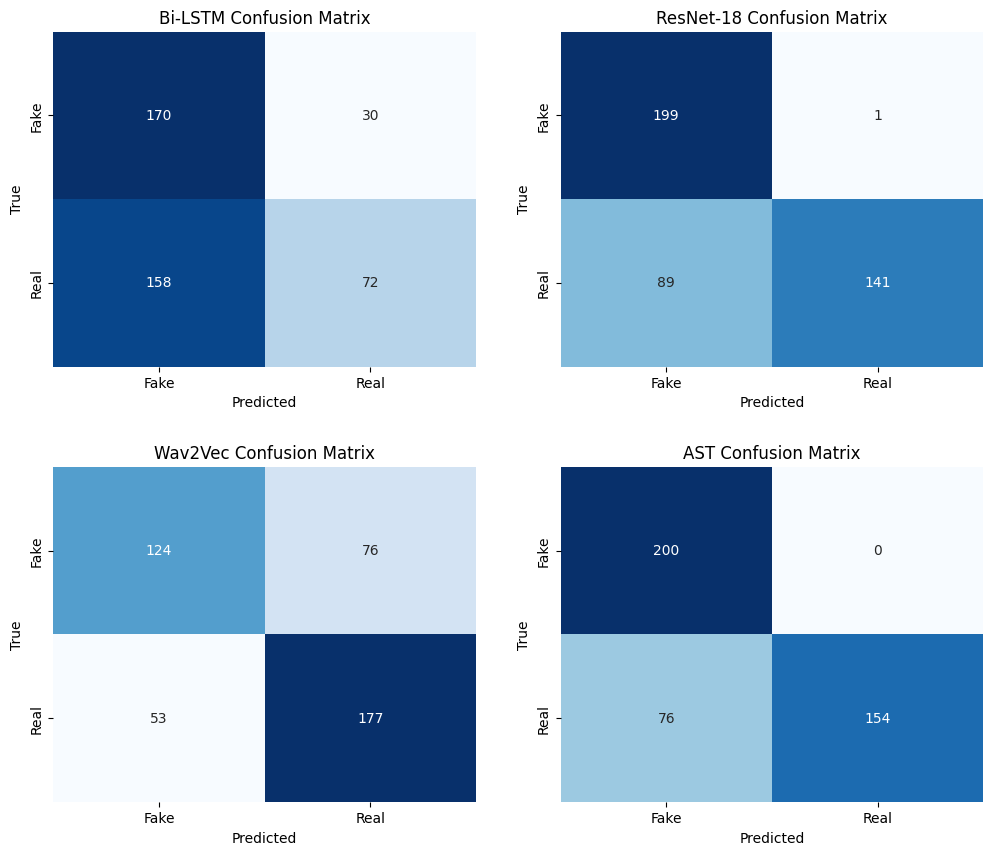

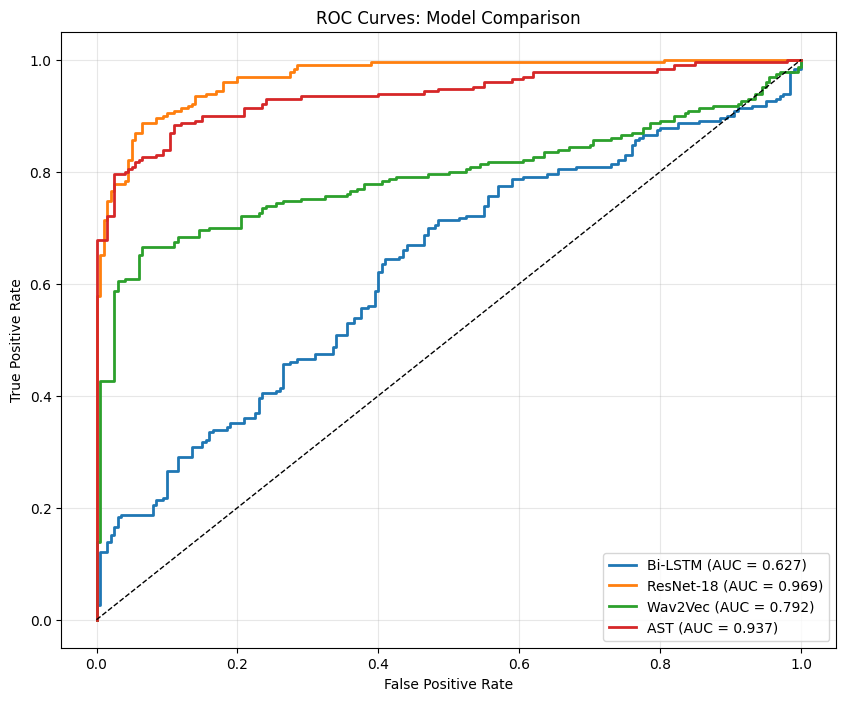

In [ ]:
# --- CELL 6: VISUALIZATION ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.3)

# 1. Confusion Matrices
for idx, (name, (yt, ys)) in enumerate(roc_data.items()):
    y_pred = (ys > 0.5).astype(int)
    cm = confusion_matrix(yt, y_pred)
    ax = axes[idx//2, idx%2]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(['Fake', 'Real'])
    ax.set_yticklabels(['Fake', 'Real'])

plt.show()

# 2. ROC Curves
plt.figure(figsize=(10, 8))
for name, (yt, ys) in roc_data.items():
    fpr, tpr, _ = roc_curve(yt, ys)
    auc_val = roc_auc_score(yt, ys)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_val:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Model Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()